# Tuning results from models
Parameters tested
1. K
2. num_kernels

In [18]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations, product

from param import *

sns.set_theme(style="whitegrid")
output_dir = ParamDir().output_dir
datalist = ParamDir().data_path_list

## K-means

In [11]:
def cal_inter_clusters_distance(cluster_centers):
    """Calculate the mean Euclidean distance between clusters.
    """
    n_clusters = cluster_centers.shape[0]
    distance_clusters = np.zeros(6)
    for combo_id, combo in enumerate(combinations(range(n_clusters), 2)):
        p, q = cluster_centers[[combo]].reshape(2,-1)
        distance_clusters[combo_id] = np.linalg.norm(p-q)
    return np.median(distance_clusters)

def cal_within_clusters_distance(inertia, X_shape):
    """Calculate the mean Euclidean distance within clusters.
    """
    n_instance = X_shape[0]
    return inertia/n_instance

### Inter cluster distance

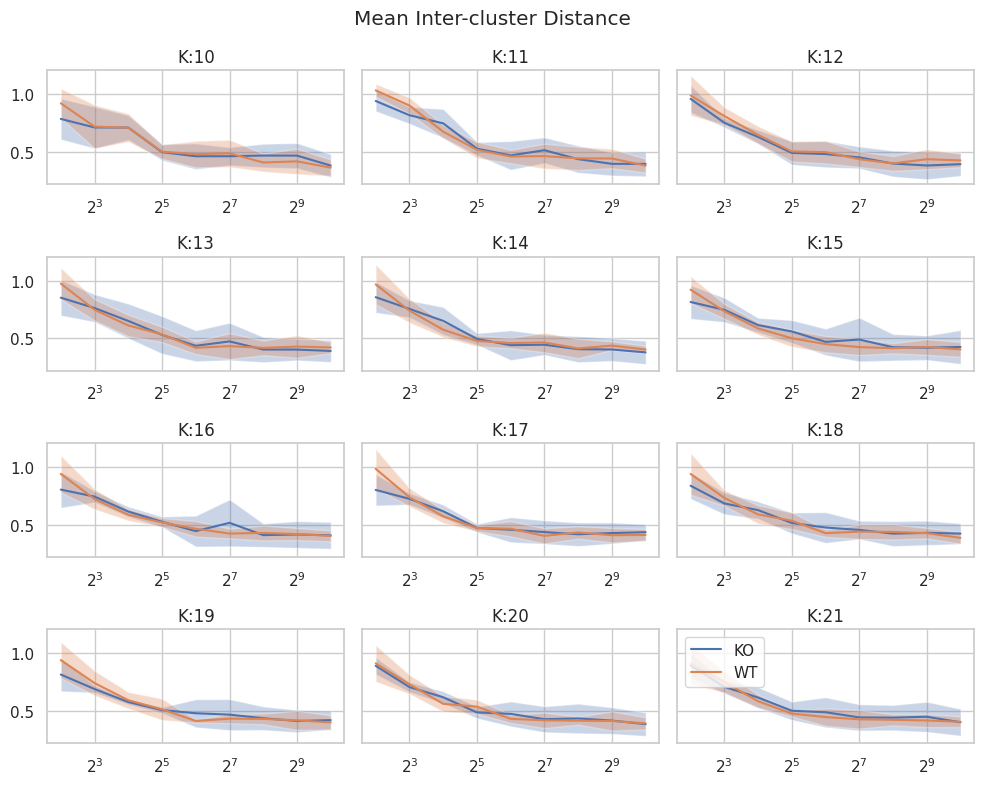

In [8]:
result_org = []
for data_dir in datalist:
    data_name = str(data_dir).split('/')[-1]
    with open(ParamDir().output_dir/data_name/(f"tsc_tuning_k_means_large_scale.pickle"),"rb") as f:
        result_all = pickle.load(f)
    for result in result_all:
        if "KO" in data_name:
            result_org.append((
                cal_inter_clusters_distance(result['estimator'].cluster_centers_), 
                result["K"], 
                result["num_kernels"], 
                "KO"))
        else:
            result_org.append((
                cal_inter_clusters_distance(result['estimator'].cluster_centers_), 
                result["K"], 
                result["num_kernels"], 
                "WT"))

df = pd.DataFrame(result_org, columns=["scores", "K", "num_kernels", "mouse_type"])

fig, axes = plt.subplots(figsize=(10,8),nrows=4, ncols=3, sharey=True, tight_layout=True)
axes = axes.ravel()
[ax.set_xscale("log", base=2) for ax in axes]

for i, K_value in enumerate(df["K"].unique()):
    ax = axes[i]
    xx = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].mean().loc["KO"]
    KO_std = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].std().loc["KO"]
    ax.plot(xx, label="KO")
    ax.fill_between(xx.index, xx-KO_std, xx+KO_std, alpha=.3)

    xx = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].mean().loc["WT"]
    WT_std = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].std().loc["WT"]
    ax.plot(xx, label="WT")
    ax.fill_between(xx.index, xx-WT_std, xx+WT_std, alpha=.3)

    ax.set_title(f"K:{K_value}")

plt.suptitle("Mean Inter-cluster Distance")
plt.legend(loc="upper left")


### Within cluster distance

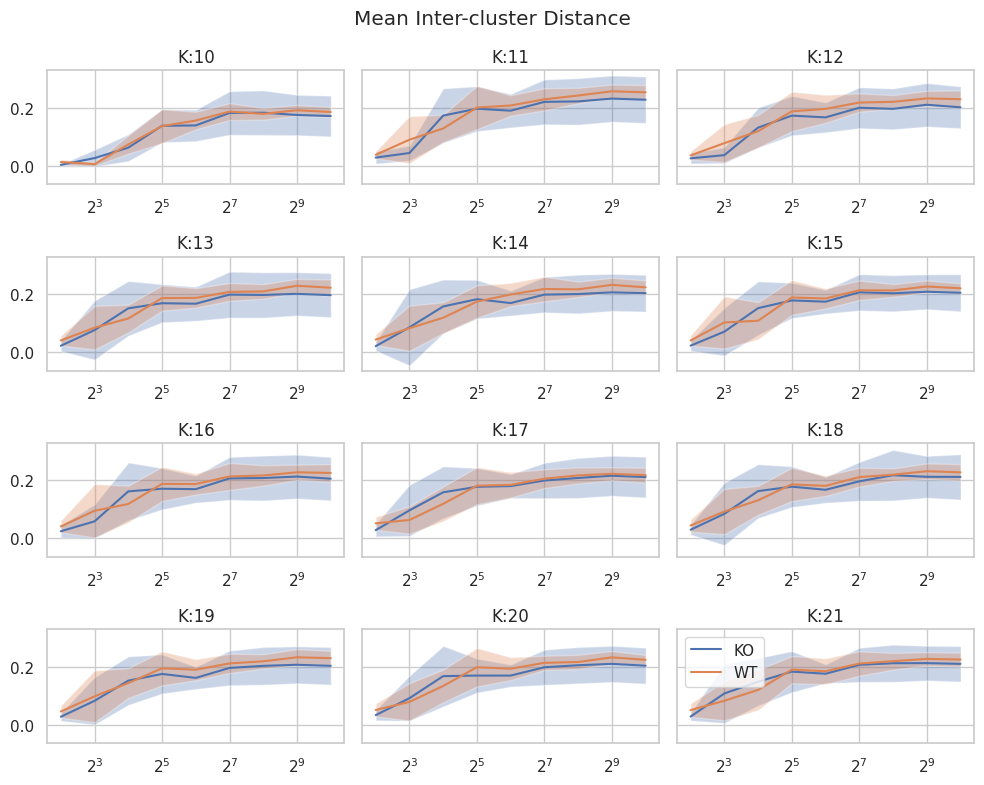

In [12]:
result_org = []
for data_dir in datalist:
    data_name = str(data_dir).split('/')[-1]
    with open(ParamDir().output_dir/data_name/(f"tsc_tuning_k_means_large_scale.pickle"),"rb") as f:
        result_all = pickle.load(f)
    for result in result_all:
        if "KO" in data_name:
            result_org.append((
                cal_within_clusters_distance(result['estimator'].inertia_, result["X_shape"]), 
                result["K"], 
                result["num_kernels"], 
                "KO"))
        else:
            result_org.append((
                cal_within_clusters_distance(result['estimator'].inertia_, result["X_shape"]), 
                result["K"], 
                result["num_kernels"], 
                "WT"))

df = pd.DataFrame(result_org, columns=["scores", "K", "num_kernels", "mouse_type"])

fig, axes = plt.subplots(figsize=(10,8),nrows=4, ncols=3, sharey=True, tight_layout=True)
axes = axes.ravel()
[ax.set_xscale("log", base=2) for ax in axes]

for i, K_value in enumerate(df["K"].unique()):
    ax = axes[i]
    xx = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].mean().loc["KO"]
    KO_std = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].std().loc["KO"]
    ax.plot(xx, label="KO")
    ax.fill_between(xx.index, xx-KO_std, xx+KO_std, alpha=.3)

    xx = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].mean().loc["WT"]
    WT_std = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].std().loc["WT"]
    ax.plot(xx, label="WT")
    ax.fill_between(xx.index, xx-WT_std, xx+WT_std, alpha=.3)

    ax.set_title(f"K:{K_value}")

plt.suptitle("Mean Inter-cluster Distance")
plt.legend(loc="upper left")


## Spectral Clustering

In [25]:
def cal_inter_cluster_similarity(affinity_matrix, clusters_labels):
    """Calculate the inter clusters similarity based on affinity matrix.
    """
    clusters= np.unique(clusters_labels)
    n_clusters = len(clusters)
    mean_inter_clusters = np.zeros(int(np.math.factorial(n_clusters)/
                                   (np.math.factorial(n_clusters-2)*np.math.factorial(2))))
    # for cluster_id, cluster in enumerate(clusters):
    for combo_id, combo in enumerate(combinations(range(n_clusters), 2)):
        sample_ids_1 = np.where(clusters_labels==combo[0])[0]
        sample_ids_2 = np.where(clusters_labels==combo[1])[0]
        filtered = affinity_matrix[sample_ids_1][:, sample_ids_2]
        # filtered = [affinity_matrix.todok()[combo_sample] for combo_sample in product(sample_ids_1, sample_ids_2)]
        mean_inter_clusters[combo_id] = np.max(filtered)
    return np.median(mean_inter_clusters)

def cal_within_cluster_similarity(affinity_matrix, clusters_labels):
    """Calculate within clusters similarity based on affinity matrix.
    """
    clusters= np.unique(clusters_labels)
    mean_inter_clusters = np.zeros(len(clusters))
    for cluster_id, cluster in enumerate(clusters):
        sample_ids = np.where(clusters_labels==cluster)[0]
        filtered = affinity_matrix[sample_ids][:, sample_ids][np.triu_indices(len(sample_ids), 1)]
        mean_inter_clusters[cluster_id] = np.mean(filtered)
    return np.mean(mean_inter_clusters)

### Inter cluster similarity

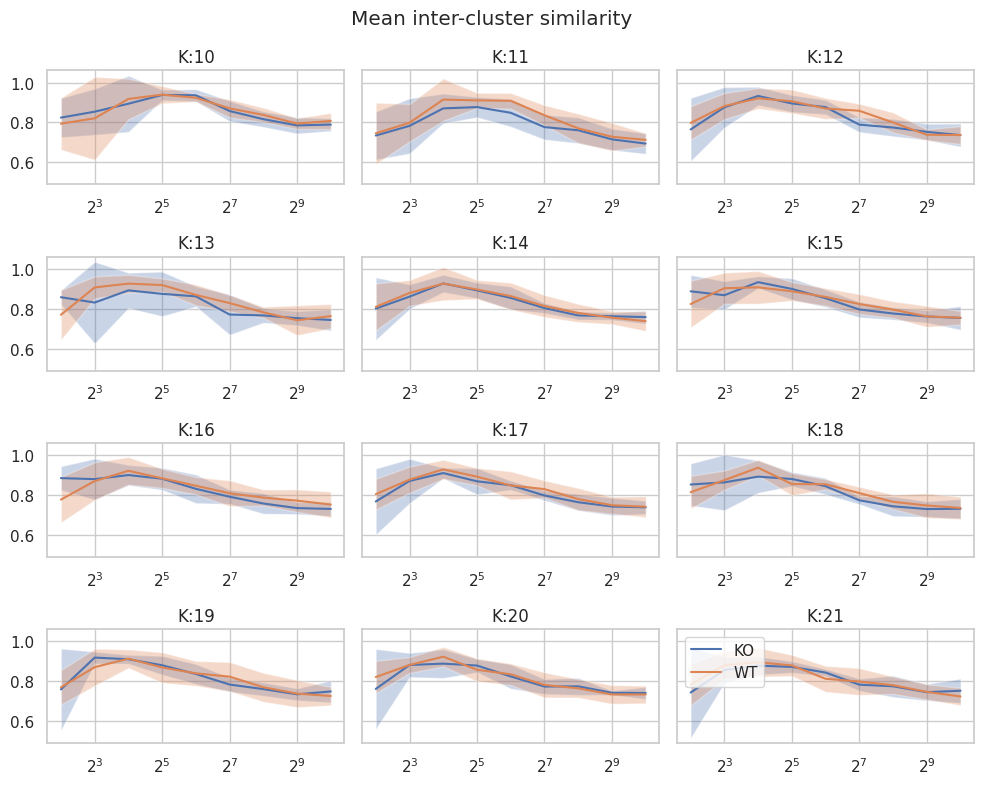

In [26]:
result_org = []
for data_dir in datalist:
    data_name = str(data_dir).split('/')[-1]
    with open(ParamDir().output_dir/data_name/(f"tsc_tuning_spectral_large_scale.pickle"),"rb") as f:
        result_all = pickle.load(f)
    for result in result_all:
        if "KO" in data_name:
            result_org.append((cal_inter_cluster_similarity(result["estimator"].affinity_matrix_, result["estimator"].labels_), result["K"], result["num_kernels"], "KO"))
        else:
            result_org.append((cal_inter_cluster_similarity(result["estimator"].affinity_matrix_, result["estimator"].labels_), result["K"], result["num_kernels"], "WT"))

df = pd.DataFrame(result_org, columns=["scores", "K", "num_kernels", "mouse_type"])

fig, axes = plt.subplots(figsize=(10,8),nrows=4, ncols=3, sharey=True, tight_layout=True)
axes = axes.ravel()
[ax.set_xscale("log", base=2) for ax in axes]

for i, K_value in enumerate(df["K"].unique()):
    ax = axes[i]
    xx = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].mean().loc["KO"]
    KO_std = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].std().loc["KO"]
    ax.plot(xx, label="KO")
    ax.fill_between(xx.index, xx-KO_std, xx+KO_std, alpha=.3)

    xx = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].mean().loc["WT"]
    WT_std = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].std().loc["WT"]
    ax.plot(xx, label="WT")
    ax.fill_between(xx.index, xx-WT_std, xx+WT_std, alpha=.3)

    ax.set_title(f"K:{K_value}")

plt.suptitle("Mean inter-cluster similarity")
plt.legend(loc="upper left")


### Within Cluster Distance

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


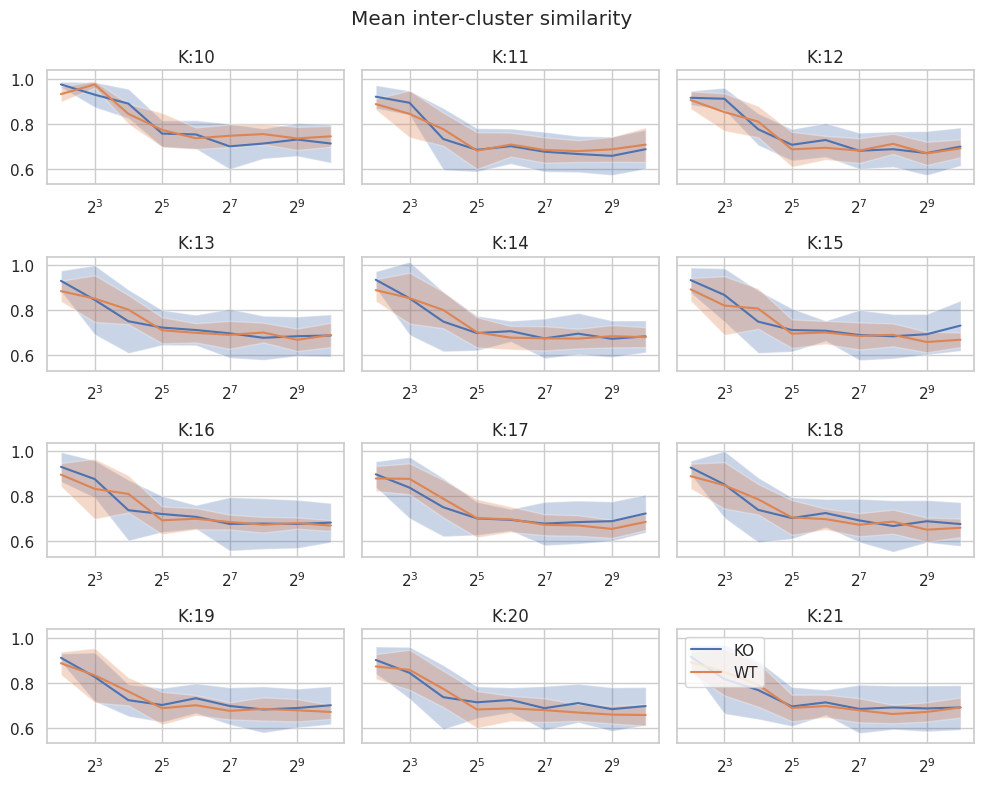

In [10]:
result_org = []
for data_dir in datalist:
    data_name = str(data_dir).split('/')[-1]
    with open(ParamDir().output_dir/data_name/(f"tsc_tuning_spectral_large_scale.pickle"),"rb") as f:
        result_all = pickle.load(f)
    for result in result_all:
        if "KO" in data_name:
            result_org.append((cal_within_cluster_similarity(result["estimator"].affinity_matrix_, result["estimator"].labels_), result["K"], result["num_kernels"], "KO"))
        else:
            result_org.append((cal_within_cluster_similarity(result["estimator"].affinity_matrix_, result["estimator"].labels_), result["K"], result["num_kernels"], "WT"))

df = pd.DataFrame(result_org, columns=["scores", "K", "num_kernels", "mouse_type"])

fig, axes = plt.subplots(figsize=(10,8),nrows=4, ncols=3, sharey=True, tight_layout=True)
axes = axes.ravel()
[ax.set_xscale("log", base=2) for ax in axes]

for i, K_value in enumerate(df["K"].unique()):
    ax = axes[i]
    xx = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].mean().loc["KO"]
    KO_std = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].std().loc["KO"]
    ax.plot(xx, label="KO")
    ax.fill_between(xx.index, xx-KO_std, xx+KO_std, alpha=.3)

    xx = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].mean().loc["WT"]
    WT_std = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].std().loc["WT"]
    ax.plot(xx, label="WT")
    ax.fill_between(xx.index, xx-WT_std, xx+WT_std, alpha=.3)

    ax.set_title(f"K:{K_value}")

plt.suptitle("Mean inter-cluster similarity")
plt.legend(loc="upper left")
